# Histogram CPU times per event for two CPUs

only from tasks where both CPUs contributed

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab

### Parameters

In [2]:
TCPU1 = 'Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz'
TCPU2 = 'Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz'
ProcessingType = 'simul' # set to None for all

### Get datasets

In [3]:
jobs = pd.read_csv('job_node_info.csv')

jobs = jobs[jobs['nevents']>20]

if ProcessingType!=None:
    jobs = jobs[jobs['processingtype']==ProcessingType]

del jobs['cputime']
del jobs['walltime']
del jobs['cpueff']
del jobs['wallPerEvent']
del jobs['inputsize']
del jobs['processingtype']

jobs.head()

,host,nevents,cpuPerEvent,taskid
2,b63ab874b9.cern.ch,1000,45.890,11374294
7,n302.t1.grid.kiae.ru,1000,362.112,11514032
9,f10-02.gina.sara.nl,1000,106.787,11453532
11,node160,1000,202.261,11453601
17,mwt2-c032,50,1.600,11430603


In [4]:
input_files=['benchmark_node_info.csv']
tmp=[]
for input_file in input_files:
    tmp.append(pd.read_csv(input_file))
benchmarks = pd.concat(tmp)

del benchmarks['ip']
del benchmarks['site']
del benchmarks['meminfo']

benchmarks.head()

,host,mpnum,cpuname,VM,cpunum,coresPerSocket,threadsPerCore
0,r25-n14.ph.liv.ac.uk,1,Intel(R) Xeon(R) CPU E5-2630 v2 @ 2.60GHz,False,24,6,2
1,cern-atlas-dcb8d293-709a-42f5-b891-8f3eface243...,8,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,True,8,1,1
2,wn-200-03-27-01-a.cr.cnaf.infn.it,8,AMD Opteron(tm) Processor 6320,False,16,4,2
3,wg60.grid.hep.ph.ic.ac.uk,8,Intel(R) Xeon(R) CPU X5650 @ 2.67GHz,False,24,6,2
4,vac037-03.beowulf.cluster,1,QEMU Virtual CPU version 1.5.3,True,8,1,1


### select only CPUs we are interested in

In [5]:
def getCPU(cpu,vm,tpc):
    res=cpu.strip()
    if tpc>1: 
        res+=" HT"
        return 'other'
    if vm: 
        res+=" VM"
        return 'other'
    if cpu !=TCPU1 and cpu!=TCPU2: 
        return "other"
    return res

benchmarks['CPU'] = benchmarks.apply(lambda x: getCPU(x['cpuname'], x['VM'], x['threadsPerCore']), axis=1)

benchmarks=benchmarks[benchmarks.CPU!='other']

del benchmarks['cpuname']
del benchmarks['VM']
del benchmarks['coresPerSocket']
del benchmarks['threadsPerCore']
del benchmarks['mpnum']
del benchmarks['cpunum']
benchmarks=benchmarks.set_index('host')
benchmarks.head()

,CPU
host,
lcg-wn14-14.icepp.jp,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz
wn-mars-030.farm.nikhef.nl,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz
wn-mars-001.farm.nikhef.nl,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz
lcg-wn15-01.icepp.jp,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz
lcg-wn05-06.icepp.jp,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz


### join dataframes and filter out unneded rows

In [6]:
jobs['CPU']=(jobs['host']).map(benchmarks['CPU'])
del jobs['host']

#jobs.CPU=jobs.processingtype
jobs=jobs.dropna()
jobs.head()


,nevents,cpuPerEvent,taskid,CPU
61,1000,79.479,11502818,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz
129,1000,411.677,11350685,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz
642,1000,417.228,11350685,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz
1090,1000,107.869,11736704,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz
1101,50,0.820,11430603,Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz


### sum-up per taskid and CPU

In [7]:
print(jobs.shape)
raw = jobs.groupby(["CPU","taskid"]).agg({'nevents': ['sum','count'], 'cpuPerEvent':['mean']})
print(raw.shape)
raw.head(20)



(98879, 4)
(777, 3)


cpuPerEvent nevents      
                                                          mean     sum count
CPU                                       taskid                            
Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz 11350628  340.200200    5000     5
                                          11350646  185.998500    2000     2
                                          11350669  353.250714    7000     7
                                          11363361  108.647800   15000    15
                                          11363370  106.631100   20000    20
                                          11363379  124.038000    2000     2
                                          11363382   96.384750   60000    60
                                          11363602   38.345500    2000     2
                                          11363621   86.463000    3000     3
                                          11363944  151.285667    3000     3
                                          11364166  347.137000    1000     1
                                          11364181  505.596000    3000     3
                                          11364191  626.533250    4000     4
                                          11364196  277.187000    1000     1
                                          11364486  140.611143   21000    21
                                          11364490  151.369875    8000     8
                                          11404711    2.540769    1300    13
                                          11404718    2.640000    1000    10
                                          11430561    0.118500    2000     2
                                          11430601    0.191600    5000     5

###  split in dataframes based on cpuname

In [8]:
df1 = raw.iloc[raw.index.get_level_values('CPU') == TCPU1]
df1.index = df1.index.droplevel(0)
print(df1.head)

df2 = raw.iloc[raw.index.get_level_values('CPU') == TCPU2]
df2.index = df2.index.droplevel(0)
print(df2.head)


<bound method NDFrame.head of          cpuPerEvent nevents      
                mean     sum count
taskid                            
10944480  545.497375    8000     8
10964322  160.909000    1000     1
11045844   50.072750    4000     4
11045866  125.737600    5000     5
11046600  150.262214   14000    14
11046619   58.012000    1000     1
11047364   64.871000    1000     1
11140025  123.406000    1000     1
11140866  127.923571    7000     7
11141818  229.765000    1000     1
11144277   99.865000    2000     2
11144707   94.867000    1000     1
11149227  104.696367   60000    60
11159455  152.730652   46000    46
11162139  130.332423  104000   104
11167070  209.925861  137000   137
11182047  180.500235  119000   119
11183081  187.255622  188000   188
11209776  153.967250    4000     4
11212570  130.593667    3000     3
11213408  141.277000    1000     1
11231750  253.903500   14000    14
11259358   93.486488  129000   129
11259378  135.370985   67000    67
11259399  158.117333    3

###  sum up data, plot

mu: 0.961285463926 sigma: 0.0612289161762


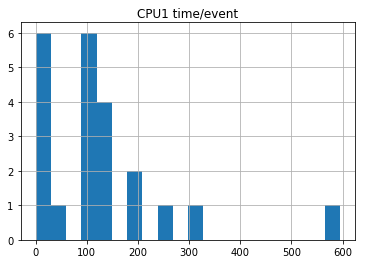

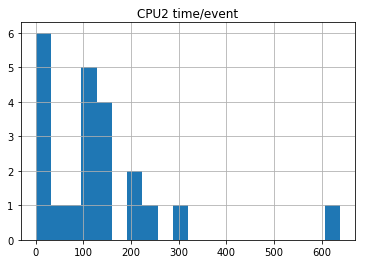

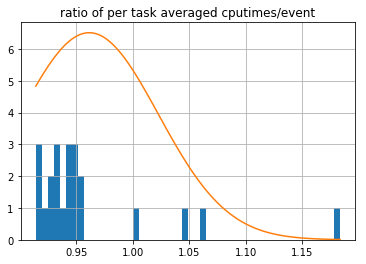

In [9]:
    #inner join in oder to remove tasks that did not have both of these CPUs
    mer=df1.join(df2, lsuffix='_f', rsuffix='_s', how='inner')
    
    mer=mer[mer['nevents_f','count']>5]
    mer=mer[mer['nevents_s','count']>5]
    
    # we weight on total time these two CPUs spent on this task
    mer['totTime'] = mer['nevents_f','sum']*mer['cpuPerEvent_f','mean'] + mer['nevents_s','sum']*mer['cpuPerEvent_s','mean']
    
    mer['frac']=mer['cpuPerEvent_f','mean']/mer['cpuPerEvent_s','mean']
    mer.hist(['cpuPerEvent_f'],bins=20)
    plt.title('CPU1 time/event')
    mer.hist(['cpuPerEvent_s'],bins=20)
    plt.title('CPU2 time/event')
    #mer.hist(['dif'],bins=bins)
    bins=50
    
    var='frac'
    (mu, sigma) = norm.fit(mer[var])
    print("mu:",mu,"sigma:", sigma)
    
    mer.hist([var],bins=bins)
    x = np.linspace(mer[var].min(), mer[var].max(),100)
    plt.plot(x,mlab.normpdf(x,mu,sigma))
    plt.title('ratio of per task averaged cputimes/event')
    
    #print(mer)

